In [154]:
import numpy as np
import matplotlib.pyplot as plt
import corsikaio as co
import subprocess
%config inlinebackend.figure_format="retina"

## Muon charge ratio

In [70]:
runnums = np.arange(2000, 2050, 1, dtype=int)
prim_energy = np.zeros(runnums.size, dtype=float)
muon_ratio = np.zeros(runnums.size, dtype=float)
muon_ratio_sigma = np.zeros(runnums.size, dtype=float)
for i, runn in enumerate(runnums):
    muonp, muonm = 0, 0
    with co.CorsikaParticleFile(f"DAT{runn:06d}") as f:
        prim_energy[i] = f.run_header[7] # Lower limit of primary energy
        _muon_ratio = np.zeros(int(f.run_header[21])) # NSHOW, number of events
        for j, event in enumerate(f):
            ids = event.particles["particle_description"] // 1000
            n_mp = np.sum(ids == 5) # number of mu+
            n_mm = np.sum(ids == 6) # number of mu-
            if n_mm * n_mp > 0:
                _muon_ratio[j] = n_mp / n_mm # Store the charge ratios in each event
                muonp += n_mp
                muonm += n_mm
        # If no muons are produced, assign the ratio to NaN 
        muon_ratio[i] = muonp / muonm if muonp * muonm > 0 else np.nan
        muon_ratio_sigma[i] = np.sqrt(np.mean((_muon_ratio - muon_ratio[i])**2))


Text(0, 0.5, 'R')

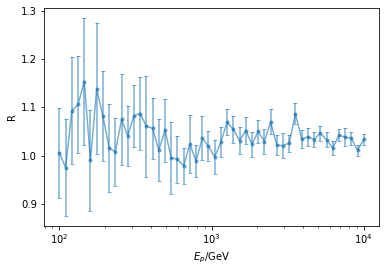

In [80]:
plt.errorbar(prim_energy, muon_ratio, yerr=muon_ratio_sigma/1e1,marker='.', capsize=2, alpha=0.6)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("$E_p$/GeV")
plt.ylabel("R")
# plt.grid("on", which="both");

## Electron to muon ratio

In [64]:
runnums = np.arange(6000, 6017, 1, dtype=int)
zenith = np.zeros(runnums.size, dtype=float)
emu_ratio = np.zeros(runnums.size, dtype=float)
emu_ratio_sigma = np.zeros(runnums.size, dtype=float)
for i, runn in enumerate(runnums):
    ne, nmu = 0, 0
    with co.CorsikaParticleFile(f"DAT{runn:06d}") as f:
        _emu_ratio = np.zeros(int(f.run_header[21])) # NSHOW, number of events
        for j, event in enumerate(f):
            ids = event.particles["particle_description"] // 1000
            _n_e = np.sum(ids == 2) + np.sum(ids == 3) # number of e+ and e-
            _n_mu = np.sum(ids == 5) + np.sum(ids == 6) # number of mu+ and mu-
            if _n_e * _n_mu > 0:
                _emu_ratio[j] = _n_e / _n_mu # Store the charge ratios in each event
                ne += _n_e
                nmu += _n_mu
        zenith[i] = np.rad2deg(event.header[10]) # zenith angle in degree of last shower event
        # If no muons are produced, assign the ratio to NaN 
        emu_ratio[i] = ne / nmu if ne * nmu > 0 else np.nan
        emu_ratio_sigma[i] = np.sqrt(np.mean((_emu_ratio - emu_ratio[i])**2))


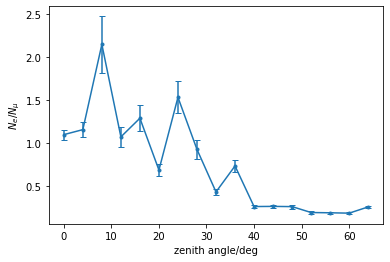

In [46]:
plt.errorbar(zenith, emu_ratio, yerr=emu_ratio_sigma/10, capsize=3, marker='.')
plt.ylabel("$N_e/N_{\mu}$")
plt.xlabel("zenith angle/deg");

## SLANT option on longitudinal development

Read average longitudinal development from .lst file,
including number of particles and (statistical) error.

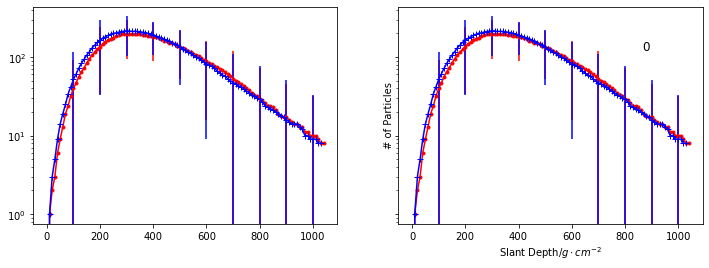

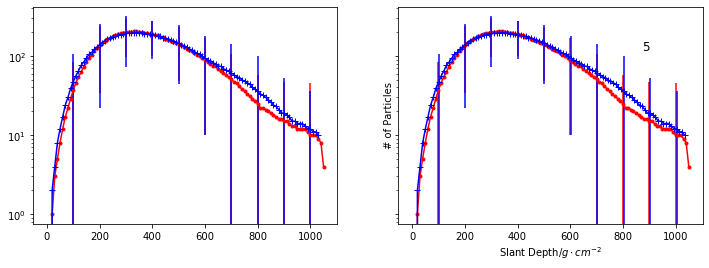

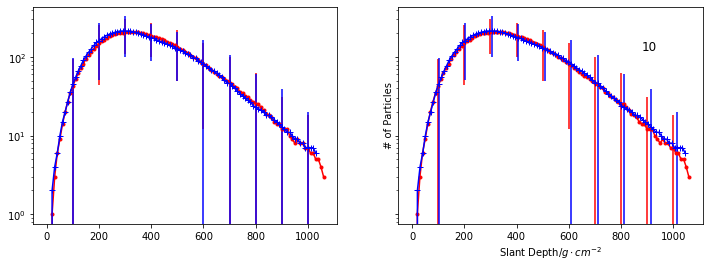

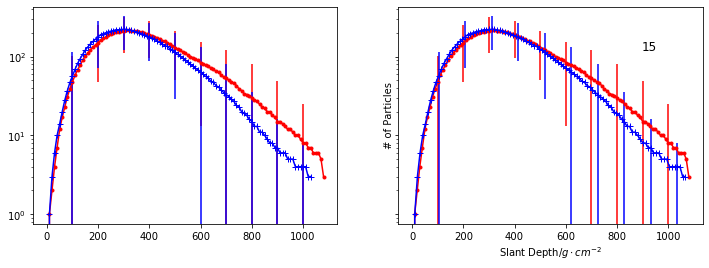

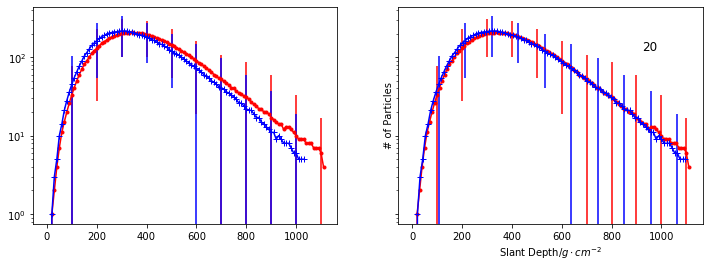

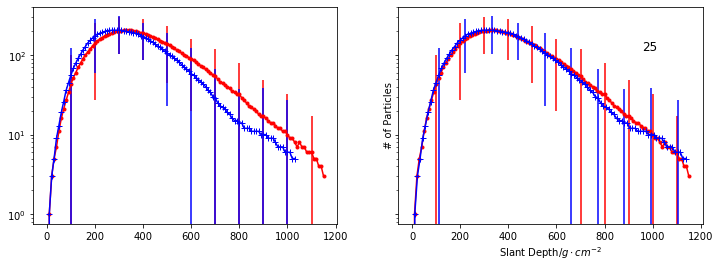

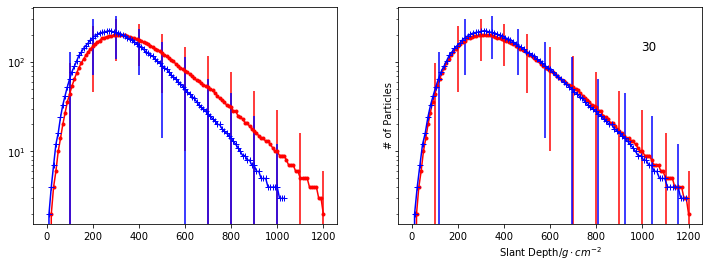

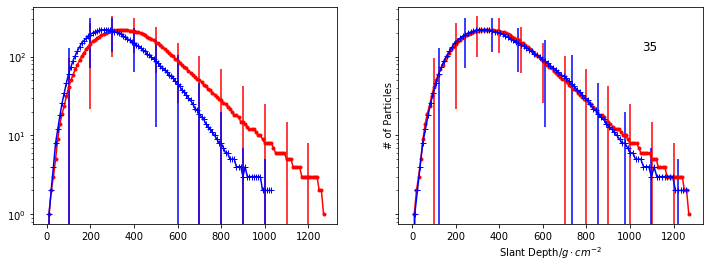

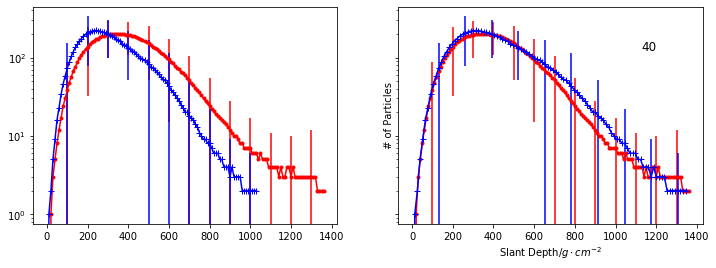

In [153]:
runnums = np.arange(0, 9, 1, dtype=int)
zenith = np.arange(0, 41, 5)
names = "depth gamma gamma_err positron positron_err electon electon_err mup mup_err mum mum_err".split(" ")
convert_func = lambda x: float(x.strip(b"+-"))
error_converter = dict(zip(names, [convert_func] * len(names)))

for i, runn in enumerate(runnums):
    output = subprocess.check_output(f"grep -n 'AVERAGE LONGITUDINAL PARTICLE' ./DAT{runn+7000:06d}.lst", shell=True)
    output = output.split(b'\n')[:-1]
    rownum1, rownum2 = [int(j.split(b':')[0]) for j in output]
    a = np.genfromtxt(f"DAT{runn+7000:06d}.lst",
                      skip_header=rownum1+3, max_rows=rownum2-rownum1-6,
                      names=names, converters=error_converter)
    output = subprocess.check_output(f"grep -n 'AVERAGE LONGITUDINAL PARTICLE' ./DAT{runn+8000:06d}.lst", shell=True)
    output = output.split(b'\n')[:-1]
    rownum1, rownum2 = [int(j.split(b':')[0]) for j in output]
    b = np.genfromtxt(f"DAT{runn+8000:06d}.lst",
                      skip_header=rownum1+3, max_rows=rownum2-rownum1-6,
                      names=names, converters=error_converter)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True)
    axs[0].errorbar(a["depth"], a["electon"], yerr=a['electon_err'],
                 color='red', marker='.', errorevery=10)
    axs[0].errorbar(b["depth"], b["electon"], yerr=b['electon_err'],
                 color='blue', marker='+', errorevery=10)
    axs[1].errorbar(a["depth"], a["electon"], yerr=a['electon_err'],
                 color='red', marker='.', errorevery=10)
    axs[1].errorbar(b["depth"] / np.cos(np.deg2rad(zenith[i])), b["electon"], yerr=b['electon_err'],
                 color='blue', marker='+', errorevery=10)
    plt.xlabel("Slant Depth/${g \cdot cm^{-2}}$")
    plt.ylabel("# of Particles")
    plt.yscale("log")
    plt.text(0.8, 0.8, f"{zenith[i]:.0f}", fontsize=12, transform=plt.gca().transAxes)
    # plt.savefig(f"slant_vertical.{zenith[i]}.png", dpi=500);

In [155]:
a["mup"]

array([ 0.,  0.,  1.,  2.,  3.,  3.,  4.,  5.,  6.,  6.,  7.,  7.,  7.,
        8.,  8.,  9.,  9., 10., 10., 11., 11., 11., 11., 11., 12., 13.,
       13., 13., 13., 13., 13., 14., 14., 14., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 14., 14., 14., 14., 14., 14., 13., 13.,
       13., 13., 13., 13., 13., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        7.,  7.,  7.,  6.,  6.,  5.,  3.])

In [18]:
a

(b'EVTH', 1., 14., 127.4275, 0., 0., 2744528.5, -0., 0., 127.42404, 0., 0., 2., [[2014.,    0.,    0.], [2015.,    0.,    0.], [   0.,    0.,    0.], [   0.,    0.,    0.], [   0.,    0.,    0.], [   0.,    0.,    0.], [   0.,    0.,    0.], [   0.,    0.,    0.], [   0.,    0.,    0.], [   0.,    0.,    0.]], 1007., 210223., 7.7402, 1., [441000.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.], -2.7, 127.4275, 127.4275, 0.3, 0.3, 0.003, 0.003, 0., 0., 0., 0., 0., 2., 20., 42.8, 1., 1., 1., 3., 0., 0., 0., 3., 0., 0., -180., 180., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 0., 0., 1., 1., 0., 0., 0., 1., 20000., 0., 0., 0., 0., 0., 0., 0., 80., 0., 0., 11282920., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., [0., 0., 0., 0., 0., 0.], [0., 0., 0., 0.,